# Replication Michael P. Keane & Kenneth I. Wopin

This notebook replicates results from: 

Keane, M. P. & Wopin, W. I. (1997). [The career Decisions of Young Men.](https://www.jstor.org/stable/10.1086/262080)
 *Journal of Political Economy, 105(3): 473-552.*

The above mentioned paper builds from a theoratical paper from:

Keane, M. P. & Wopin, W. I., & Vytlacil, E. J. (1994). 
[The Solution and Estimation of Discrete Choice Dynamic Programming Models by Simulation and Interpolation: Monte Carlo Evidence.](https://www.jstor.org/stable/2109768)
 *The Review of Economics and Statistics, 76(4): 648-672.*

For this purpose l rely on *respy*. Respy is an open-source Python package for the simulation and estimation of a prototypical finite-horizon discrete choice dynamic programming model.


# Section 1: Background

#### Groundwork 

This project builds upon collaboration and contributions to the *respy* and *estimagic* open source pacakges. In particular, l have worked with some of the open source contributors of these packages to develop parts of the code.

For the *respy* package, l have integrated the results of a project l previously completed on [benchmarking various implementations of ols and iv ](https://github.com/lindamaok899/least_squares). This was done to drop all statsmodels dependencies in the package in favor of incorporating a faster method of calculating ols estimates. I have also integrated a root mean squared error (rmse) function in the package for the same purpose.

For the *estimagic* package, l have worked on the documentation of the numerical optimisers used in the package. In particular, l have created reference dictionaries for the different arguments that relate to the various implemented numerical optimizers.

For both packages and an additional project (*uncertainty quantification project*), l have also calculated standard errors for parameter estimates of likelihood models. More specifically, l write functions that construct the full covariance matrix of the estimated parameters. There are different ways to calculate those covariance matrices, but in all cases they are based on derivatives of the log likelihood function. I have also written a function that extracts the diagonal elements of these covariance matrices to contstuct a 1d array of containing the standard errors. After this, l have written a benchmarking module that compares the functions to the statsmodels output to ensure complete accuracy of the covariance matrices. Lastly, l have written tests to all the encorprated functions. The under-the-hood workings of this part of my assignment can be viewed in the estimagic repository under open source economics [here](https://github.com/OpenSourceEconomics/estimagic/tree/master/estimagic/inference). Subsequently, l will encorporate the neccesary functions for the replication in the auxilliary folder if neccesary.


#### Authors' motivation

This paper provides structural estimates of schooling, work and occupational choice decisions based on 11 years of observations on a sample of 1400 white young men from the 1979 youth cohort of the National Longitudinal Surveys of Labor Market Experience (NLSY). The authors ingeminate the importance of encorporating self selection for an accurate assessment of the differential productivity of human capital investment. In their paper, they extend earlier (prior to 1997) work done in the this field by considering self-selection in the three dimensions of schooling, work and occupational choice. More specifically, they extend the static deterministic setting of earlier models (Heckman and Sedlacek, 1985; Willis, 1986), each of which is an extension of the basic Roy (1951) framework, to a model in which decision making is sequential and the environment is uncertain.

The structural approach in Keane and Wopin (1997) provides rigorous interpretations for the parameters that are estimated, which has several important implications for ex-ante policy evaluation such as:

1) predicting the effect an intervention that provides college tuition subsidies has on college attendance rates and subsequent occupational choice decisions

2) assessing the welfare effects of interventions on lifetime wealth and utility, allowing policy makers to draw distributional consequences of them 

To implement the model, the participants are assigned in each year to one of five discrete, mutually exclusive alternatives: attending school, working in a white collar occupation, working in a blue collar occupation, working in the military or engaging on home production.

#### Theoretical framework

#### Causal Graph representation

# Section 2: Descriptive statistics & visualisation

#### Data loaading and pre-proccessing

I first conduct some basic preperation of the data to increase readability.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")

# Ensure proper formatting of the wage variable
pd.options.display.float_format = '{:,.2f}'.format

# Label and format the different columns
columns = ['Identifier', 'Age', 'Schooling', 'Choice', 'Wage']
dtype = {'Identifier': np.int, 'Age': np.int,  'Schooling': np.int,  'Choice': 'category'}

# Read the original data file
df = pd.DataFrame(np.genfromtxt('data/KW_97.raw'), columns=columns).astype(dtype)

# Label the different choice categories
df['Choice'].cat.categories = ['Schooling', 'Home', 'White', 'Blue', 'Military']

# Set the index for easier interpretability
df['Period'] = df['Age'] - 16
df.set_index(['Identifier', 'Period'], inplace=True, drop=True)

#### Data description

All individuals enter the model initially at the same age and are then observed for a varying number of consecutive years. Each year, the individual's decision to work in either a white or blue collar occupation, attend school, enroll in the miliary, or remain at home is recorded. If the individual is working, the dataset potentially also contains that year's wage as a full-time equivalent.

In [3]:
# preview the data
df.head(10)

Age  Schooling     Choice      Wage
Identifier Period                                     
6          0        16         11  Schooling       nan
           1        17         12  Schooling       nan
           2        18         13  Schooling       nan
           3        19         14  Schooling       nan
           4        20         15  Schooling       nan
           5        21         16       Home       nan
           6        22         16      White 14,062.67
           7        23         16      White 15,921.17
           8        24         16      White 18,602.73
           9        25         16      White 19,693.95

#### Sample size distribution

In [59]:
# to be done

#### Average real wage by occupation as in Table 4

In [8]:
tab = pd.crosstab(index=df['Age'], columns=df['Choice'], values=df['Wage'], aggfunc='mean', margins=True)
tab[['All', 'White', 'Blue', 'Military']]

Choice,All,White,Blue,Military
Age,,,,
16,"10,217.74","9,320.76","10,286.74",nan
17,"11,036.60","10,049.76","11,572.89","9,005.36"
18,"12,060.75","11,775.34","12,603.82","10,171.87"
19,"12,246.68","12,376.42","12,949.84","9,714.60"
20,"13,635.87","13,824.01","14,363.66","10,852.51"
21,"14,977.00","15,578.14","15,313.45","12,619.37"
22,"17,561.28","20,236.08","16,947.90","13,771.56"
23,"18,719.84","20,745.56","17,884.95","14,868.65"
24,"20,942.42","24,066.64","19,245.19","15,910.84"


To visualise this in plot form, we can plot the results as below:

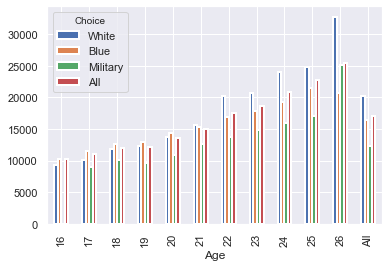

In [51]:
tab.plot(kind='bar', stacked=False, linewidth=2.0)
plt.show()

#### Average age by choice

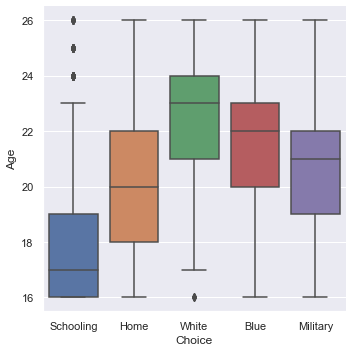

In [28]:
sns.catplot(x="Choice", y="Age", kind="box", data=df)
plt.show()

#### Average school attainment by choice

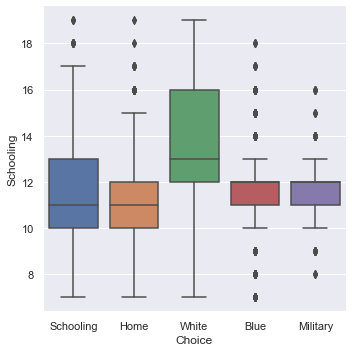

In [26]:
sns.catplot(x="Choice", y="Schooling", kind="box", data=df)
plt.show()

#### Share of individuals across the different choices as in Table 1

In [34]:
table = pd.crosstab(index=df['Age'], columns=df['Choice'], margins=True)
table

Choice,Schooling,Home,White,Blue,Military,All
Age,,,,,,
16,1178,145,4,45,1,1373
17,1014,197,15,113,20,1359
18,561,296,92,331,70,1350
19,420,293,115,406,107,1341
20,341,273,149,454,113,1330
21,275,257,170,498,106,1306
22,169,212,256,559,90,1286
23,105,185,336,546,68,1240
24,65,112,284,416,44,921


Distribution of individuals across different alternatives as plot:

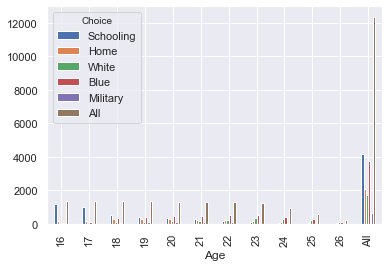

In [53]:
table.plot(kind='bar', stacked=False, linewidth=1.0)
plt.show()

## Section 3: Replication of main result

#### Contribution to replicating KW1997

Here l make use of the functions l have written that calculate covariance matrices for hessian and jacobian matrices. These functions have since been encorporated into the [estimagic/inference](https://github.com/OpenSourceEconomics/estimagic/tree/master/estimagic/inference) folder for calculating standard errors. The tests for these functions can also be found in the [estimagic/tests/inference](https://github.com/OpenSourceEconomics/estimagic/tree/master/estimagic/tests/inference) folder.

## Section 4: Discussion & Conclusion

## References